# **Loan Default Prediction - Model Building**

--------------------------------
### **Context** 
-------------------------------
A major proportion of retail bank profit comes from interests in the form of home loans. These loans are borrowed by regular income/high earning customers. Banks are most fearful of defaulters, as bad loans (NPA) usually eat up a major chunk of their profits. Therefore, it is important for banks to be judicious while approving loans for their customer base.

The approval process for the loans is multifaceted. Through this process, the bank tries to check the creditworthiness of the applicant on the basis of a manual study of various aspects of the application. The entire process is not only effort-intensive but also prone to wrong
judgment/approval owing to human error and biases. 

There have been attempts by many banks to automate this process by using heuristics. But with the advent of data science and machine learning, the focus has shifted to building machines that can learn this approval process and make it free of biases and more efficient. At the same time, one important thing to keep in mind is to make sure that the machine does not leam the biases that
previously crept in because of the human approval process.

----------------------------
### **Objective**
-----------------------------
A bank's consumer credit department aims to simplify the decision-making process for home equity lines of credit to be accepted. To do this, they will adopt the Equal Credit Opportunity Act's guidelines to establish an empirically derived and statistically sound model for credit scoring. The model will be based on the data obtained via the existing loan underwriting process from recent applicants who have been given credit. The model will be built from predictive modeling techniques, but the model created must be interpretable enough to provide a justification for any adverse behavior (rejections).

* Build a classification model to predict clients who are likely to default on their loan
* Give recommendations to the bank on the important features to consider while approving a loan. 

--------------------------
### **Data Description**
--------------------------
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property. 

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts) 

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments). 

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due). 

* **CLAGE:** Age of the oldest credit line in months. 

* **NINQ:** Number of recent credit inquiries. 

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## **Importing Data**

### **Import the necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score,recall_score,f1_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

import scipy.stats as stats

from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

### **Read the dataset**

In [2]:
hm=pd.read_csv("hmeq.csv")

# Copying data to another variable to avoid any changes to original data
data=hm.copy()

### **Convert the data types**

In [3]:
cols = data.select_dtypes(['object']).columns.tolist()

#adding target variable to this list as this is an classification problem and the target variable is categorical

cols.append('BAD')

In [4]:
cols

['REASON', 'JOB', 'BAD']

In [5]:
# Changing the data type of object type column to category.
for i in cols:
    data[i] = data[i].astype('category')

## Treating Outliers

In [6]:
def treat_outliers(df,col):
    '''
    treats outliers in a varaible
    col: str, name of the numerical varaible
    df: data frame
    col: name of the column
    '''
    
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR= Q3 - Q1   # IQR Range
    Lower_Whisker = Q1 - 1.5*IQR   #define lower whisker
    Upper_Whisker = Q3 + 1.5*IQR  # define upper Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whishker will be assigned value of upper_Whisker 
    return df

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical varaibles
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df,c)
        
    return df

In [7]:
df_raw = data.copy()

numerical_col = df_raw.select_dtypes(include=np.number).columns.tolist()# getting list of numerical columns

df = treat_outliers_all(df_raw,numerical_col)

### **Checking that outliers have been removed**

In [8]:
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

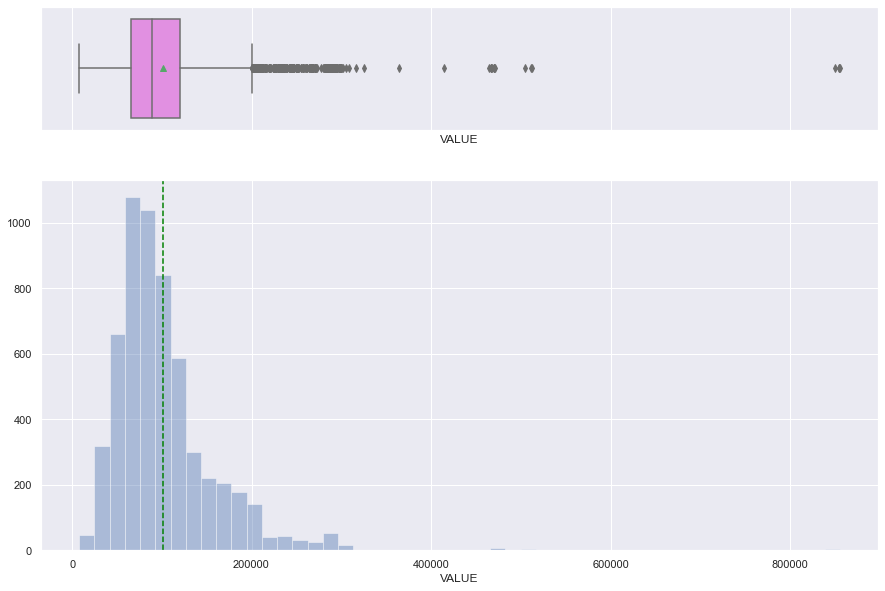

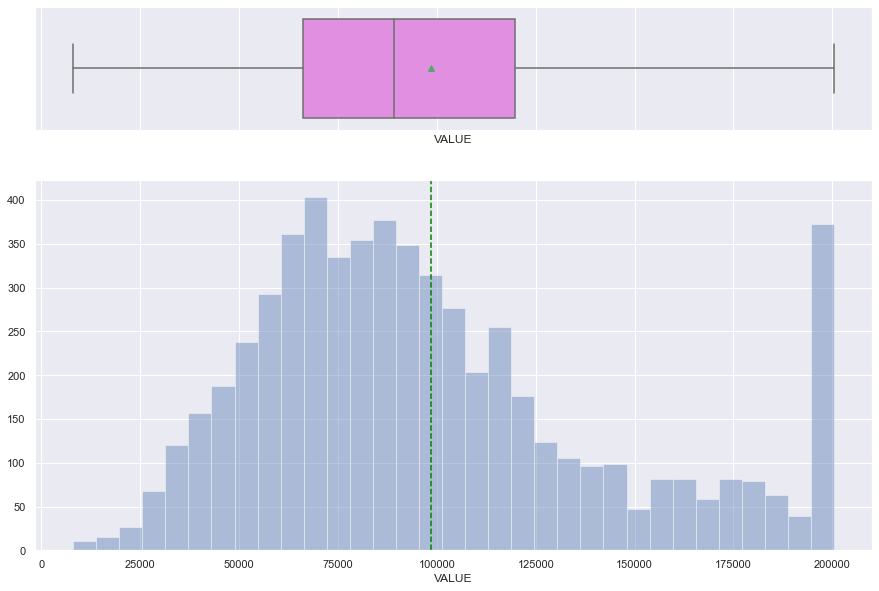

In [9]:
histogram_boxplot(data['VALUE'])
histogram_boxplot(df_raw['VALUE'])

## **Treating Null Values**

#### Adding new columns in the dataset for each column which has missing values 

In [10]:
#For each column we create a binary flag for the row, if there is missing value in the row, then 1 else 0. 
def add_binary_flag(df,col):
    '''
    df: It is the dataframe
    col: it is column which has missing values
    It returns a dataframe which has binary falg for missing values in column col
    '''
    new_col = str(col)
    new_col += '_missing_values_flag'
    df[new_col] = df[col].isna()
    return df

In [11]:
# list of columns that has missing values in it
missing_col = [col for col in df_raw.columns if df_raw[col].isnull().any()]

for colmn in missing_col:
    add_binary_flag(df_raw,colmn)
    

In [12]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,VALUE_missing_values_flag,REASON_missing_values_flag,JOB_missing_values_flag,YOJ_missing_values_flag,DEROG_missing_values_flag,DELINQ_missing_values_flag,CLAGE_missing_values_flag,NINQ_missing_values_flag,CLNO_missing_values_flag,DEBTINC_missing_values_flag
0,1,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,False,False,False,False,False,False,False,False,False,True
1,1,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,0.0,121.833333,...,False,False,False,False,False,False,False,False,False,True
2,1,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,False,False,False,False,False,False,False,False,False,True
3,1,1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
4,0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,False,False,False,False,False,False,False,False,False,True


#### Filling missing values in numerical columns with median and mode in categorical variables

In [13]:
#  Treat Missing values in numerical columns with median and mode in categorical variables
# Select numeric columns.
num_data = df.select_dtypes('number')

# Select string and object columns.
cat_data = df.select_dtypes('category').columns.tolist() #df.select_dtypes('object')

# Fill numeric columns with median.
df[num_data.columns] = num_data.fillna(num_data.median())

# Fill object columns with mode.
for column in cat_data:
    mode = df[column].mode()[0]
    df[column] = df[column].fillna(mode)

In [14]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,VALUE_missing_values_flag,REASON_missing_values_flag,JOB_missing_values_flag,YOJ_missing_values_flag,DEROG_missing_values_flag,DELINQ_missing_values_flag,CLAGE_missing_values_flag,NINQ_missing_values_flag,CLNO_missing_values_flag,DEBTINC_missing_values_flag
0,1,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,False,False,False,False,False,False,False,False,False,True
1,1,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,0.0,121.833333,...,False,False,False,False,False,False,False,False,False,True
2,1,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,False,False,False,False,False,False,False,False,False,True
3,1,1500.0,65019.0,89235.5,DebtCon,Other,7.0,0.0,0.0,173.466667,...,True,True,True,True,True,True,True,True,True,True
4,0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,False,False,False,False,False,False,False,False,False,True


#### Drop Missing Values Flag Columns

In [15]:
list(df.columns)

['BAD',
 'LOAN',
 'MORTDUE',
 'VALUE',
 'REASON',
 'JOB',
 'YOJ',
 'DEROG',
 'DELINQ',
 'CLAGE',
 'NINQ',
 'CLNO',
 'DEBTINC',
 'MORTDUE_missing_values_flag',
 'VALUE_missing_values_flag',
 'REASON_missing_values_flag',
 'JOB_missing_values_flag',
 'YOJ_missing_values_flag',
 'DEROG_missing_values_flag',
 'DELINQ_missing_values_flag',
 'CLAGE_missing_values_flag',
 'NINQ_missing_values_flag',
 'CLNO_missing_values_flag',
 'DEBTINC_missing_values_flag']

In [16]:
#Drop Null Flag Columns 
df_clean = df.drop(['MORTDUE_missing_values_flag',
 'VALUE_missing_values_flag',
 'REASON_missing_values_flag',
 'JOB_missing_values_flag',
 'YOJ_missing_values_flag',
 'DEROG_missing_values_flag',
 'DELINQ_missing_values_flag',
 'CLAGE_missing_values_flag',
 'NINQ_missing_values_flag',
 'CLNO_missing_values_flag',
 'DEBTINC_missing_values_flag'], axis =1)

df_clean.info()
print('*'*50)
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   BAD      5960 non-null   category
 1   LOAN     5960 non-null   float64 
 2   MORTDUE  5960 non-null   float64 
 3   VALUE    5960 non-null   float64 
 4   REASON   5960 non-null   category
 5   JOB      5960 non-null   category
 6   YOJ      5960 non-null   float64 
 7   DEROG    5960 non-null   float64 
 8   DELINQ   5960 non-null   float64 
 9   CLAGE    5960 non-null   float64 
 10  NINQ     5960 non-null   float64 
 11  CLNO     5960 non-null   float64 
 12  DEBTINC  5960 non-null   float64 
dtypes: category(3), float64(10)
memory usage: 483.7 KB
**************************************************


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262
1,1,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,0.0,121.833333,0.0,14.0,34.818262
2,1,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262
3,1,1500.0,65019.0,89235.5,DebtCon,Other,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262
4,0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262


## **Data Preparation**

### **Separating the target variable from other variables**

In [17]:
# Drop the dependent variable from the dataframe and create the X(independent variable) matrix
X = df_clean.drop(columns = 'BAD') #make a copy called X which is a dataframe with "BAD" removed

# Create y(dependent varibale)
Y = df_clean['BAD'] #Y is a series (column) containing the "BAD" label data

# Create dummy variables for the categorical variables
X = pd.get_dummies(X, drop_first = True)

#pd.get_dummies => working on X dataframe converts all cathegorical variables into binary 1/0 yes/no columns.

### **Splitting the data into 70% train and 30% test set**

In [18]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 1)

## **Model Evaluation Criterion**
Model is attempting to find defaulters(1), which will be our True Positive(TP), and therefore non-defaulters(0) will be our True Negative(TN)

**Model can make wrong predictions as:**

1. Predicting a applicant will not default on a loan but, in reality, the applicant would default results in major loss in profits.
2. Predicting a applicant will default on a loan but, in reality, the applicant would have paid it off results in the bank loosing profit from the interest of that potential customer.  

**Which case is more important?** 

* Banks are more fearfull of defaulters as that results in greater losses, and therefore must be more judicious when approving loans. 

**How to reduce the losses?**

* The bank would want `recall` to be maximized. The greater the recall score, higher the chances of minimizing **False Negative**. 
* In this case the false negative is **predicting an applicant will not default(0), when the applicant would default(1)**
* That being said a high F1-Score is still preferable as that would result in more profits, as long as recall remains high.

## **Metric Formula**

In [19]:
#creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## **Model Results Table**

In [20]:
#Create a table 
results = pd.DataFrame(columns = ['Model_Name','Train_f1','Train_recall','Test_f1','Test_recall','Test_precision'])

results.head()

,Model_Name,Train_f1,Train_recall,Test_f1,Test_recall,Test_precision


## **Build a Decision Tree Base Model**

In [21]:
#Defining Decision tree model with class weights class_weight={0: 0.2, 1: 0.8} to address data imbalance

d_tree_base = DecisionTreeClassifier(random_state = 7, class_weight = {0: 0.2, 1: 0.8})


In [22]:
#fitting Decision tree model
d_tree_base.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3355
           1       1.00      1.00      1.00       817

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



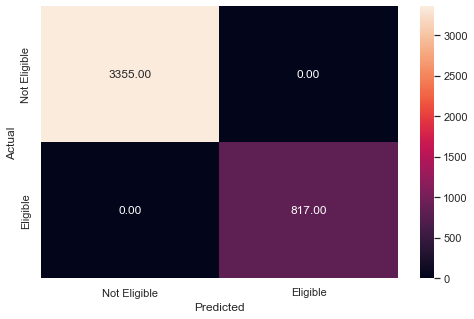

In [23]:
# Checking performance on the training data
y_pred_train1 = d_tree_base.predict(X_train)

metrics_score(y_train,y_pred_train1)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1416
           1       0.65      0.57      0.61       372

    accuracy                           0.85      1788
   macro avg       0.77      0.75      0.76      1788
weighted avg       0.84      0.85      0.84      1788



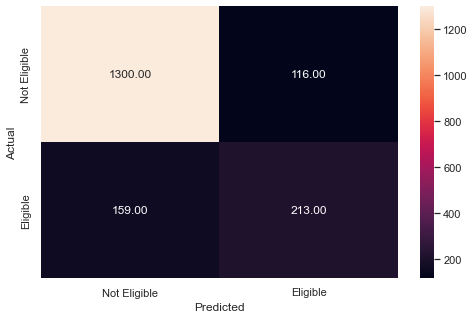

In [24]:
# Checking performance on the testing data
y_pred_test1 = d_tree_base.predict(X_test)

metrics_score(y_test,y_pred_test1)

**Add data to results table**

In [25]:
results = results.append({'Model_Name':'d_tree_base',
                          'Train_f1':100,
                          'Train_recall':100,
                          'Test_f1':61,
                          'Test_recall':57,
                         'Test_precision':65},
                            ignore_index=True)
results

,Model_Name,Train_f1,Train_recall,Test_f1,Test_recall,Test_precision
0,d_tree_base,100,100,61,57,65


**Insights**
* The base model is highly overfitted with the testing data scoring well below the training data.
* The model also has higher preision to recall score, the oposite of what we wanted. 
* Overall this is a very poor model. 

## **Decision Tree - Hyperparameter Tuning**

* Hyperparameter tuning using **Grid search** which is a tuning technique that attempts to compute the optimum values of hyperparameters.
* **It is an exhaustive search** that is performed on the specific parameter values of a model.
* The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.

**Criterion {“gini”, “entropy”}**

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth** 

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf**

The minimum number of samples is required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

#### Using GridSearchCV for Hyperparameter tuning on the model

In [26]:
# Choose the type of classifier. 
d_tree_tuned = DecisionTreeClassifier(random_state = 7, class_weight = {0: 0.2, 1: 0.8})

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2, 6), #dept [2, 3, 4, 5]
              'criterion': ['gini', 'entropy'], #use both gini and entropy to measure split quality
              'min_samples_leaf': [5, 10, 20, 25] #minimum number of samples to be a leaf node
             }


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search
grid_obj = GridSearchCV(d_tree_tuned, parameters, scoring = scorer, cv = 5) #=> chooses the best hyperparameters to use

grid_obj = grid_obj.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
d_tree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
d_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=5,
                       min_samples_leaf=25, random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      3355
           1       0.59      0.79      0.68       817

    accuracy                           0.85      4172
   macro avg       0.77      0.83      0.79      4172
weighted avg       0.88      0.85      0.86      4172



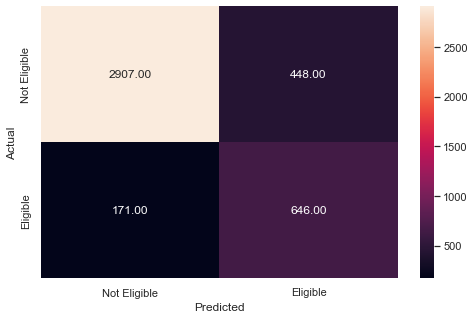

In [27]:
# Checking performance on the training data based on the tuned model
y_pred_train2 = d_tree_tuned.predict(X_train)

metrics_score(y_train,y_pred_train2)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1416
           1       0.60      0.75      0.67       372

    accuracy                           0.85      1788
   macro avg       0.77      0.81      0.78      1788
weighted avg       0.86      0.85      0.85      1788



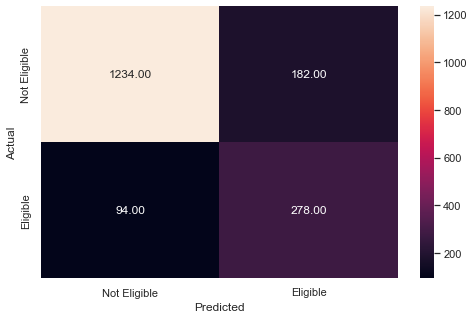

In [28]:
# Checking performance on the testing data based on the tuned model
y_pred_test2 = d_tree_tuned.predict(X_test)

metrics_score(y_test,y_pred_test2)

**Add data to results table**

In [29]:
results = results.append({'Model_Name':'d_tree_tuned',
                          'Train_f1':68,
                          'Train_recall':79,
                          'Test_f1':67,
                          'Test_recall':75,
                         'Test_precision':60},
                            ignore_index=True)
results

,Model_Name,Train_f1,Train_recall,Test_f1,Test_recall,Test_precision
0,d_tree_base,100,100,61,57,65
1,d_tree_tuned,68,79,67,75,60


**Insights**
* The tuned model is now only slightly overfitted with a training f1-score of 68 and a testing f1-score of 67.
* The model is performing much higher on recall over precision, which is preferable since we are minimizing false negatives. 
* **However, the model is overall significantly less accurate**. Therefore we need to try and maintain these ratios while improoving overall accuracy. 

#### **Plotting the Decision Tree**

**Defaulters[1]-Blue and Non-Defaulter[0]-ORANGE**

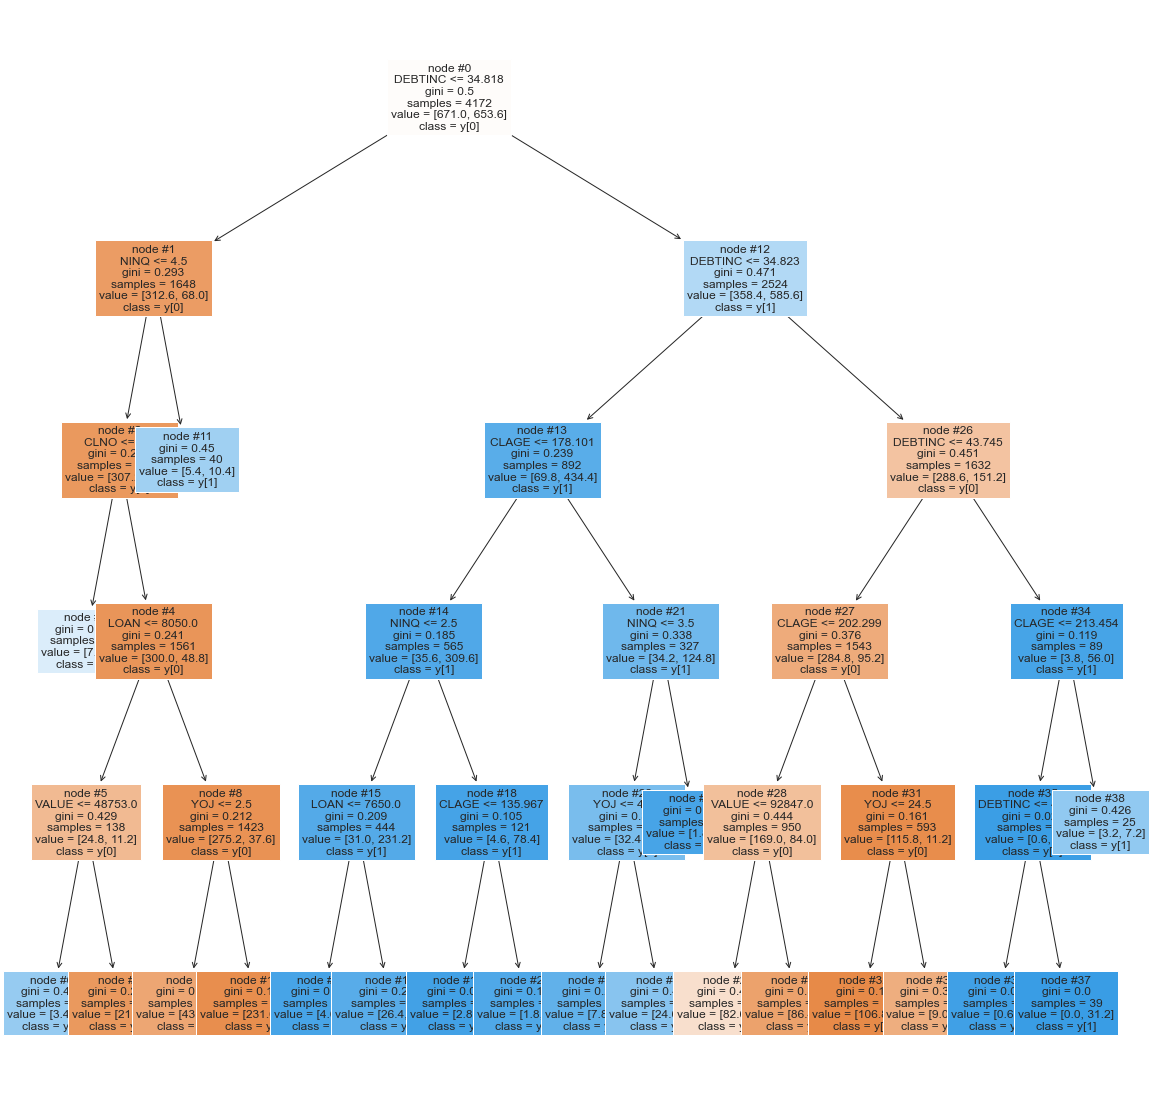

In [30]:
# Plot the decision  tree and analyze it to build the decision rule
features = list(X.columns)

plt.figure(figsize = (20, 20))

tree.plot_tree(d_tree_tuned, feature_names = features, filled = True, fontsize = 12, node_ids = True, class_names = True)

plt.show()

##### **Buisness Insights**
* The first split is made on `DEBTINC` (Debt-to-income ratio) which means it has a high ability to predict defaulters 
    * Where a higher a DEBTINC indicates the applicant is more likely to default
    * This is consistent with our observations in EDA
* The next high priority splits are made on:
    * `NINQ`(Number of recent credit inquiries) - Where a higher NINQ is more likely to default
    * `CLAGE` (Age of the oldest credit line in months) - Where a lower ClAGE is more likely to defualt
    * These where not apparent as strong indicators in EDA indicating that many indicators fall in the scope of DEBTINC, where NINQ and CLAGE have less overlap.
    

#### **Plotting Feature Importance**

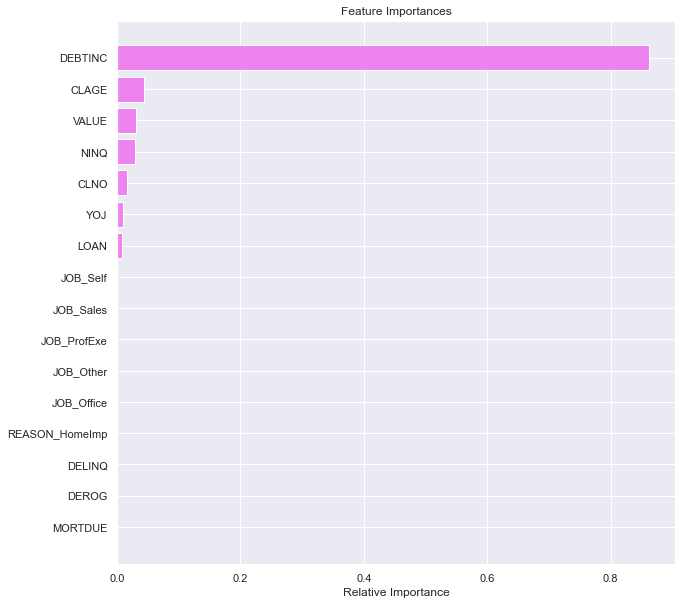

In [31]:
# Plotting the feature importance
importances = d_tree_tuned.feature_importances_

indices = np.argsort(importances)

plt.figure(figsize = (10, 10))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [features[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()

##### **Buisness Insights**
* Highlights just how much of a dominant feature `DEBTINC` is compared to the others.
* `CLAGE` (age of oldest credit line in months), `VALUE` (Current value of the property) and `NINQ` (number of recent credit inquiries) are also a impactfull feature
    * Where lower VALUE is more likely to default
    * Where lower CLAGE is more likely to default
    * Where higher NINQ is more likely to default
* `CLNO` (number of existing credit lines) | `YOJ` (years at present job) | `LOAN` (loan amount), are the only other features that have an impact. 
    * Surprising that `DEROG` (number of serious delinquency or late payments) and `DELINQ`(number of delinquent credit lines) did not show any impact given our EDA suggesting they might. 
    * Surprising that `JOB_SALES` and `JOBS_SELF` did not show any impact given our EDA suggesting they might.

### **Random Forest Classifier**

**Random Forest is a bagging algorithm where the base models are Decision Trees.** Samples are taken from the training data and on each sample a decision tree makes a prediction. 

**The results from all the decision trees are combined together and the final prediction is made using voting or averaging.**

In [32]:
# Defining Random forest CLassifier
rf_base = RandomForestClassifier(random_state=7,criterion="entropy")

rf_base.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3355
           1       1.00      1.00      1.00       817

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



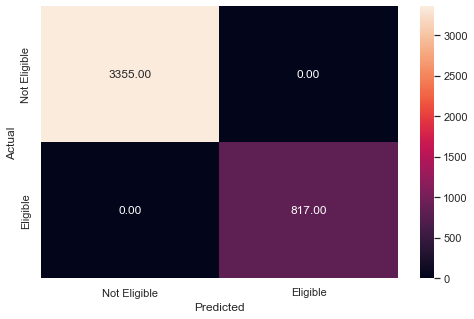

In [33]:
#Checking performance on the training data
y_pred_train3 = rf_base.predict(X_train)

metrics_score(y_train,y_pred_train3)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1416
           1       0.85      0.62      0.71       372

    accuracy                           0.90      1788
   macro avg       0.88      0.79      0.83      1788
weighted avg       0.89      0.90      0.89      1788



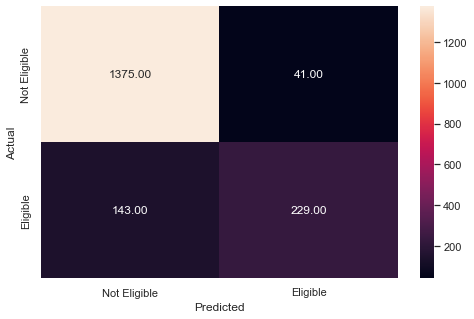

In [34]:
# Checking performance on the test data
y_pred_test3 = rf_base.predict(X_test)

metrics_score(y_test, y_pred_test3)

**Add data to results table**

In [35]:
results = results.append({'Model_Name':'rf_base',
                          'Train_f1':100,
                          'Train_recall':100,
                          'Test_f1':71,
                          'Test_recall':62,
                         'Test_precision':85},
                            ignore_index=True)
results

,Model_Name,Train_f1,Train_recall,Test_f1,Test_recall,Test_precision
0,d_tree_base,100,100,61,57,65
1,d_tree_tuned,68,79,67,75,60
2,rf_base,100,100,71,62,85


**Observations:**
* The base random forest model is highly overfitted as expected
* It is naturally favoring precision, the oposite of what we want

### **Random Forest model with Class Weights**

In [36]:
# Defining Random Forest model with class weights class_weight={0: 0.2, 1: 0.8}
rf_weighted = RandomForestClassifier(random_state = 7, class_weight = {0: 0.2, 1: 0.8})

# Fitting Random Forest model
rf_weighted.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3355
           1       1.00      1.00      1.00       817

    accuracy                           1.00      4172
   macro avg       1.00      1.00      1.00      4172
weighted avg       1.00      1.00      1.00      4172



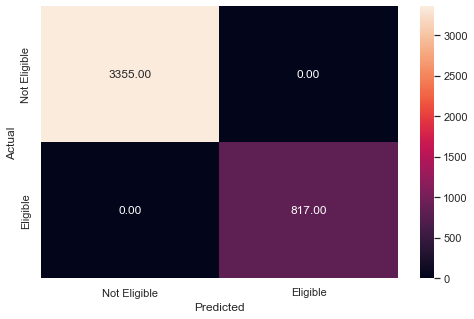

In [37]:
# Checking performance on the train data
y_pred_train4 = rf_weighted.predict(X_train)

metrics_score(y_train,y_pred_train4)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1416
           1       0.85      0.57      0.68       372

    accuracy                           0.89      1788
   macro avg       0.88      0.77      0.81      1788
weighted avg       0.89      0.89      0.88      1788



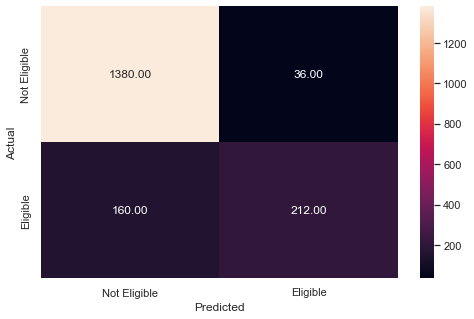

In [38]:
# Checking performance on the test data
y_pred_test4 = rf_weighted.predict(X_test)

metrics_score(y_test, y_pred_test4)

**Add data to results table**

In [39]:
results = results.append({'Model_Name':'rf_weighted',
                          'Train_f1':100,
                          'Train_recall':100,
                          'Test_f1':68,
                          'Test_recall':57,
                         'Test_precision':85},
                            ignore_index=True)
results

,Model_Name,Train_f1,Train_recall,Test_f1,Test_recall,Test_precision
0,d_tree_base,100,100,61,57,65
1,d_tree_tuned,68,79,67,75,60
2,rf_base,100,100,71,62,85
3,rf_weighted,100,100,68,57,85


**Observations:**
* Oddly weighting the random forest has dropped both our f1-score and recall. 

### **Random Forest- Hyperparameter Tuning**

 We'll use Grid search to perform hyperparameter tuning.
 * **Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters.** 
 * **It is an exhaustive search** that is performed on the specific parameter values of a model.
 * The parameters of the estimator/model used to apply these methods are **optimized by cross-validated grid-search** over a parameter grid.


**n_estimators**: The number of trees in the forest.

**min_samples_split**: The minimum number of samples required to split an internal node:

**min_samples_leaf**: The minimum number of samples required to be at a leaf node. 

**max_features{“auto”, “sqrt”, “log2”, 'None'}**: The number of features to consider when looking for the best split.

- If “auto”, then max_features=sqrt(n_features).

- If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

- If “log2”, then max_features=log2(n_features).

- If None, then max_features=n_features.

In [40]:
# Choose the type of classifier 
rf_tuned = RandomForestClassifier(criterion = "entropy", random_state = 7)

# Grid of parameters to choose from
parameters = {"n_estimators": [100, 110],
    "max_depth": [5,6],
    "max_leaf_nodes": [8,10],
    "min_samples_split":[20],
    'criterion': ['gini'],
    "max_features": ['sqrt'],
    "class_weight": ["balanced",{0: 0.2, 1: 0.8}]
             }

# Type of scoring used to compare parameter combinations - recall score for class 1
scorer = metrics.make_scorer(recall_score, pos_label = 1)

# Run the grid search on the training data using scorer=scorer and cv=5

grid_obj = GridSearchCV(rf_tuned, parameters, scoring = scorer, cv = 5)

grid_obj = grid_obj.fit(X_train, y_train)

# Save the best estimator to variable rf_estimator_tuned
rf_tuned = grid_obj.best_estimator_

#Fit the best estimator to the training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       max_features='sqrt', max_leaf_nodes=8,
                       min_samples_split=20, random_state=7)

#### Checking the performance on the train dataset

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      3355
           1       0.47      0.84      0.60       817

    accuracy                           0.78      4172
   macro avg       0.71      0.80      0.73      4172
weighted avg       0.86      0.78      0.80      4172



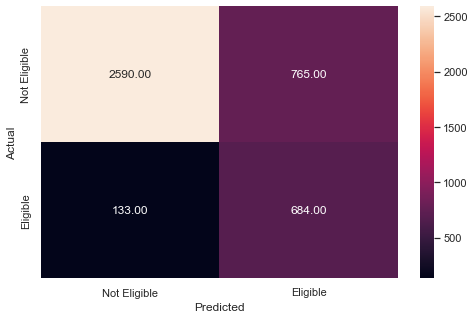

In [41]:
# Checking performance on the training data
y_pred_train5 = rf_tuned.predict(X_train)

metrics_score(y_train, y_pred_train5)

#### Checking the performance on the test dataset

              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1416
           1       0.48      0.80      0.60       372

    accuracy                           0.78      1788
   macro avg       0.71      0.79      0.72      1788
weighted avg       0.84      0.78      0.80      1788



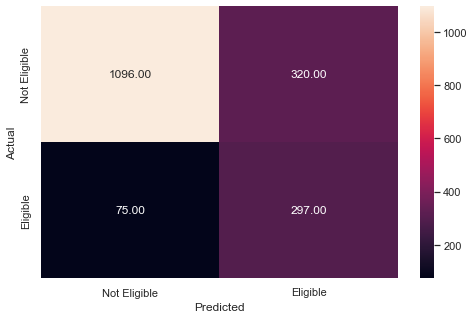

In [42]:
# Checking performace on test dataset
y_pred_test5 = rf_tuned.predict(X_test)

metrics_score(y_test, y_pred_test5)

In [43]:
results = results.append({'Model_Name':'rf_tuned',
                          'Train_f1':60,
                          'Train_recall':84,
                          'Test_f1':60,
                          'Test_recall':80,
                         'Test_precision':48},
                            ignore_index=True)
results

,Model_Name,Train_f1,Train_recall,Test_f1,Test_recall,Test_precision
0,d_tree_base,100,100,61,57,65
1,d_tree_tuned,68,79,67,75,60
2,rf_base,100,100,71,62,85
3,rf_weighted,100,100,68,57,85
4,rf_tuned,60,84,60,80,48


**Insights:**
* The model is no longer overfitted with a equal training and testing f1-score of 60%.
* After multiple tunnings, we can conclude that the limited dataset makes it difficult to achieve a high accuracy; however was able to tune the model to maximize recall and achieve a score of 80%.


**Defaulters[1]-Blue and Non-Defaulter[0]-ORANGE**

#### Plot the Feature importance of the tuned Random Forest

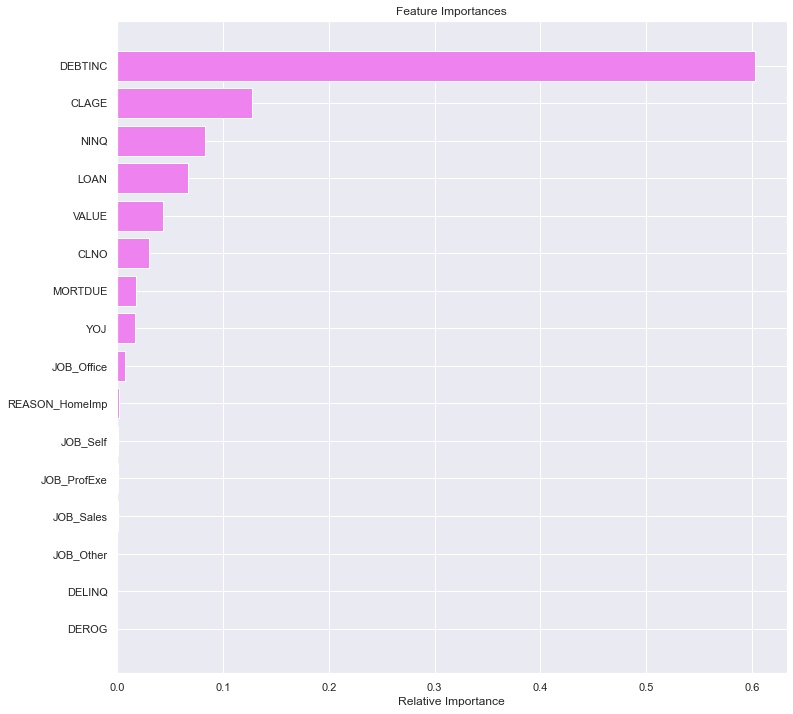

In [44]:
# importance of features in the tree building 
importances = rf_tuned.feature_importances_

indices = np.argsort(importances)

feature_names = list(X.columns)

plt.figure(figsize = (12, 12))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()

**Insights:**
* Random forest feature importance confirms many of the same features as the one done above. 
* `DEBTINC` continues to be a dominant feature
* `CLAGE`, `VALUE` and `NINQ` continue to show relevant importance
* `Loan` has increased in importance
    * where a smaller loan is more likely to default

## **Conclusion and Recommendations**

### **Reminder of Objectives**

* Build a classification model to predict clients who are likely to default on their loan
    * Maximizing `Recall` (false negatives) as banks are more fearfull of defaulters given they result in greater loss. 
    * Preferably maintaining a high `F1-Score` (overall accuracy) as false positives would result in a loss of interest profit for the bank. 
* Give recommendations to the bank on the important features to consider while approving a loan. 

### **Conclusions:**
#### **Model Performance**
It became clear as we refined the models that the size (5960 data points) and composition (80/20 non-defaulters to defaulters) of the dataset was contributing to lower that ideal accuracy scores. Therefore, our initial objective of maximizing recall and maintaining a high f1-score was unlikely, and therefore we shifted to **focus solely on maximizing recall** even at the expense of overall accuracy. 

We built multiple decision tree based models that can predict if a loan is likely to default, of those two models performed and generalized well:
* Tuned Decision Tree Model - f1-score 67% and recall 75%
* Hyper Tuned Random Forest Model - f1-score 60% and recall 80%

The two models are evenly balanced, with the tuned model being leaning more towards overall accuracy and the random forest model leaning more towards recall. For the reasons stated above it is preferable to maximize recall even at the expense of accuracy, therefore, it is **recomended we use the Hyper Tuned Random Forest Model**.

With the challenge of a limited dataset, we were able to successfully able to tune our model to maximize a **recall score of 80%.**

--------------------------------
#### **Feature Importance**

Looking at feature importances, we can say that **`DEBTINC` (Debt-to-income ratio)** is a dominant predictor of defaulters, where a higher DEBTINC indicates the applicant is more likely to default. This makes sense as applicants who owe more money than they are bringing are likely to struggle with paying off any new loans.

The only other features that showed significant impact are: `CLAGE`, `VALUE`, `NINQ` and `Loan`. All other features showed little to no impact on predicting defaulters.
* Where a lower `VALUE` is more likely to default
* Where a lower `CLAGE` is more likely to default
* Where a higher `NINQ` is more likely to default
* Where a lower `Loan` is more likely to default
--------------------------------
#### **Exploratory Data Analysis**

While `DEROG` and `DELINQ` did not show a high feature impact, EDA clearly showed that a DEROG>6 and DELINQ>5 always resulted in a default. Further it showed that it was only in a few cases that that the bank gave out loans to those with a `DEROG` and `DELINQ` greater than 0.

EDA also showed that the different cathegories of `JOB` had reletively equal percentages of defaulters.

### **Business Recommendations**

Debt to income ratio is a very powerfull tool in predicting defaulters. 
* The bank can use debt to income ratio as a initial indicator when evaluating a loan. 
* Those with a higher dept to income ratio can also be made aware of the potential difficulties of paying off a loan when already in a larger portion of depbt to income. Potentially even counsiling those on how to lower their debt or raise their income to qualify for future loans. 

Those who have a higher value of their current property and are asking for a larger loan are generally more likely not to default. This makes sense as those who are wealthier are more financialy stable.
* It is important to not develope biase towards those who are less wealthy and potentially deny them the opertunity to grow into a better living. Therefore rather than a hard cut off banks can use this metric as a means to be more critical or feel more secure in providing loans. 

EDA showed that banks likely have a hard rule of not giving loans to those with a DEROG and DELINQ greater than 0. This prooves to be prudent as each DEROG>6 and DELINQ>5 resulted in a defaults.
* It is therefore questionable why there are perhaps cases where an exeption is being made. If would be perhaps prudent to dig deeper into why those cases where given approval and limit such action in the future. 
* At the very least we can confidently use those metrics as a hard line, denying applicants outright who have a DEROG>6 and DELINQ>5, or perhaps even one step lower given the the default rate was right skewed for both. 

EDA showed that certain jobs have a higher portion of loans compared to others, this despite the fact that each had reletively equal default percentages. 
* If the bank is giving out loans preferably to certain jobs, this should be mitigated as there is no indication that any job is less likely to default. Rather such actions would deny the bank potential profits from those jobs that are given less access. 
* If the banks is giving out loans equally and certain jobs are simply applying more, than that presents an opertunity. For those jobs that are applying less, it could be benificial to research why that is and if they could be converted into potential customers. 

